#### output weights 2 layer,  validation set, graph plot, test set, lstm cell stack, preloaded full data before training, fetch data from another notebook, added exection time of 1 epoch and remaining time, .

In [1]:
from sklearn import metrics
import tensorflow as tf
#import csv
#from threading import Thread
import time
from matplotlib import pyplot as plt
from  read_proces_data import *

In [2]:
# hidden units for lstm
hidden_units = 32
# Lstm layers
num_layers = 2
# chunks of input given to lstm at a time for training
batch_size = 20
# max seq length in training and test data
max_seq = 3260
# input dimension
feature_vec_len = 57

In [3]:
# find max no of times to roll back
#max_seq_len = find_max_seq_len()
#print max_seq_len
max_seq_len = 3259

In [4]:
# use ipython feature to read data from another notebook
% store -r inde_featuress
% store -r sseq_len
% store -r target_valuess

In [5]:
sess = tf.InteractiveSession()

In [6]:
# create lstm cell in tensorflow
def lstm_cell():
    return tf.contrib.rnn.BasicLSTMCell(num_units =\
        hidden_units,state_is_tuple=True)
stacked_cell = tf.contrib.rnn.MultiRNNCell(\
        [lstm_cell() for _ in range(num_layers)], \
        state_is_tuple=True)

In [7]:
x = tf.placeholder(tf.float32, shape = [batch_size,max_seq,feature_vec_len])
s_len = tf.placeholder(tf.int32,shape=[batch_size])
# run lstm over different sequence length
output_, state = tf.nn.dynamic_rnn(\
        stacked_cell,\
        x,\
#        initial_state = i_state,\
        sequence_length=s_len,\
        dtype=tf.float32)
# take all batch, last output of each batch and full output vector
def take_subarray(array , index):
    return array[range(0,batch_size),index-1]
output = tf.py_func(take_subarray,[output_,s_len],tf.float32)
#print output
# define final output value
target_value = tf.placeholder(tf.float32, shape=[batch_size])
# define weights and bias from output of lstm cell to network final output
output_size = stacked_cell.output_size
std = 1/np.sqrt(feature_vec_len,dtype=np.float32)

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=std,dtype=tf.float32)
    return tf.Variable(initial,dtype=tf.float32)

def bias_variable(shape):
    initial = tf.constant(std, shape=shape,dtype=tf.float32)
    return tf.Variable(initial,dtype=tf.float32)

Wo1 = weight_variable([output_size, 2 * output_size])
Wo2 = weight_variable([2*output_size, 2 * output_size])
Wo3 = weight_variable([2*output_size, 2 * output_size])
Wo4 = weight_variable([2*output_size, 1])

b1 = bias_variable([2 * output_size])
b2 = bias_variable([2 * output_size])
b3 = bias_variable([2 * output_size])
b4 = bias_variable([1])

# initialize variables
# calculate final output

s1  = tf.matmul(output, Wo1) + b1
o1 = tf.nn.relu(s1)

s2  = tf.matmul(o1, Wo2) + b2
o2 = tf.nn.relu(s2)

s3  = tf.matmul(o2, Wo3) + b3
o3 = tf.nn.relu(s3)

logits  = tf.matmul(o3, Wo4) + b4
observed = tf.sigmoid(logits)
#observed = tf.nn.relu(logits)

# calculate cost as calculated in logistic classification.
logistic_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(\
        labels = tf.reshape(target_value,[batch_size,1]), logits = logits))
#cost = tf.reduce_mean(-1.0 * target_value * tf.log(observed) - \
#        (1 - target_value) * tf.log(1 - observed))
#cost = tf.reduce_mean(-1 * target_value * tf.log(observed))
#cost = tf.reduce_mean(tf.square(target_value - observed))
# optimize the cost
train_step = tf.train.AdamOptimizer(1e-4).minimize(logistic_cost)
def threshold_fn(array):
    return array >= 0.50
obser = tf.py_func(threshold_fn,[observed], tf.bool)
observe = tf.cast(obser,tf.float32)

sess.run(tf.global_variables_initializer())

In [8]:
def file_evaluate(data):
    # evaluate over whole file
    y = np.zeros(0)
    if "Sess05" in data[0]:
#                print file_
#                print inde_features.shape
        for index in range(0,100,batch_size):
#                    print inde_features[index:index+batch_size].shape                    
            #print inde_features.shape
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][index:index+batch_size], \
                s_len:data[2][index:index+batch_size]})
            y = np.append(y,yfile)
    else:
        for index in range(0,60,batch_size):
            yfile = sess.run(observe, feed_dict = {\
                x:data[1][index:index+batch_size], \
                s_len:data[2][index:index+batch_size]})
            y = np.append(y,yfile)

    f1score = metrics.f1_score(data[3],y)
#    print "f1-score of file is %f"%f1score
    fprr, tprr, thresholds = metrics.roc_curve(data[3], y, pos_label=1)
    aucc = metrics.auc(fprr,tprr)
#    print "area under curve of file is %f"%aucc
    sk_acc = metrics.accuracy_score(data[3],y)
#    print "accuracy of file is %f"%sk_acc
#    print " "
    return (f1score, aucc, sk_acc)

In [9]:
def train_eval(train_data, val_data):
    max_iter = 1
    for i in range(0,max_iter):
        tr_fe, sl , tv =\
        sample_data(train_data[1],train_data[3],train_data[2],batch_size)

        sess.run(train_step, feed_dict = {target_value:tv,\
                x:tr_fe, s_len:sl})

        if i == max_iter-1:
            #print "iteration %d"%i
            #print "cost %f"%sess.run(logistic_cost, feed_dict = {target_value:tv,\
            #    x:tr_fe, s_len:sl})
            # collect values to print graph later
            t_f1s, t_auc, t_acc = file_evaluate(train_data)
            train_para.append([t_f1s, t_auc, t_acc])
            # collect values to print graph later
            v_f1s, v_auc, v_acc = file_evaluate(val_data)
            vali_para.append([v_f1s, v_auc, v_acc])
            
#            y = sess.run(observe, feed_dict = {x:tr_fe, s_len:sl})            
#            f1s = metrics.f1_score(tv,y)
#            print "f1-score is %f"%f1s
#            fpr, tpr, thresholds = metrics.roc_curve(tv, y, pos_label=1)
#            auc = metrics.auc(fpr,tpr)
#            print "area under curve is %f"%auc
#            sk_accuracy = metrics.accuracy_score(tv,y)
#            print "accuracy %f"%sk_accuracy

In [ ]:
def plot_parameters(training_p, validation_p):
    nu_para = training_p.shape[1]
    para_name = ['f1score','auc','accuracy']
    for j in range(nu_para):
        plt.subplot(nu_para,1,j+1)
        plt.plot(training_p[:,j],'r')
        plt.plot(validation_p[:,j],'b')
        plt.ylabel(para_name[j])
        plt.grid()
    plt.show()

iteration 0


/home/gnl/TF/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


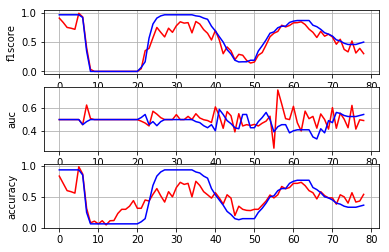

time(in minutes) for 1 epoch 3.473693
remaining time(in minutes) 3470.219225
iteration 1


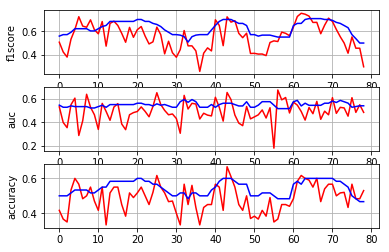

time(in minutes) for 1 epoch 3.470025
remaining time(in minutes) 3463.084767
iteration 2


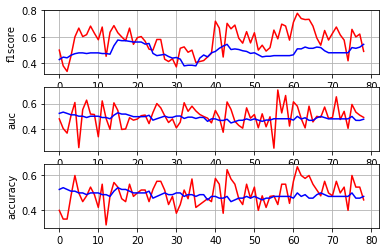

time(in minutes) for 1 epoch 4.370913
remaining time(in minutes) 4357.800361
iteration 3


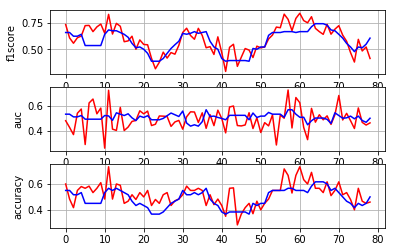

time(in minutes) for 1 epoch 3.466515
remaining time(in minutes) 3452.649174
iteration 4


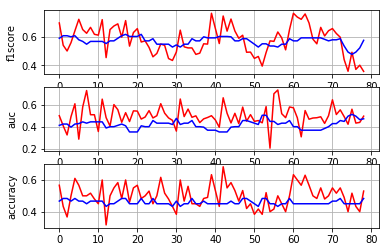

time(in minutes) for 1 epoch 3.469368
remaining time(in minutes) 3452.021639
iteration 5


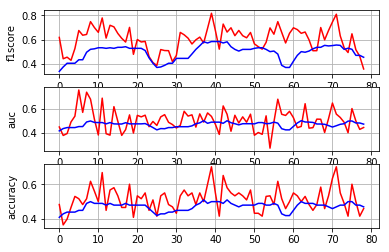

time(in minutes) for 1 epoch 4.376244
remaining time(in minutes) 4349.986766
iteration 6


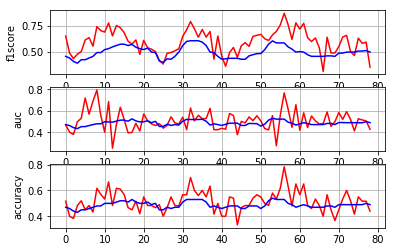

time(in minutes) for 1 epoch 4.378111
remaining time(in minutes) 4347.463825
iteration 7


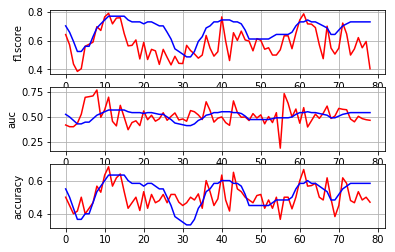

time(in minutes) for 1 epoch 3.467096
remaining time(in minutes) 3439.359251
iteration 8


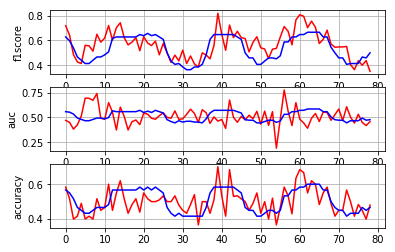

time(in minutes) for 1 epoch 3.463968
remaining time(in minutes) 3432.791822
iteration 9


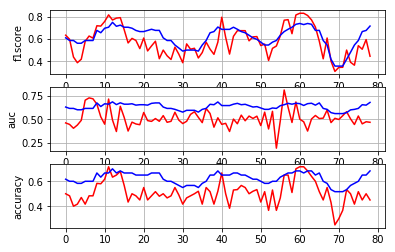

time(in minutes) for 1 epoch 3.470801
remaining time(in minutes) 3436.092592
iteration 10


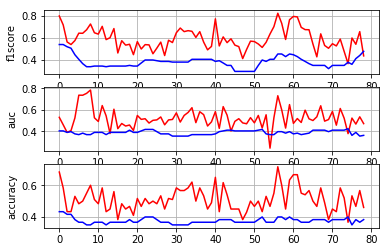

time(in minutes) for 1 epoch 3.474931
remaining time(in minutes) 3436.707240
iteration 11


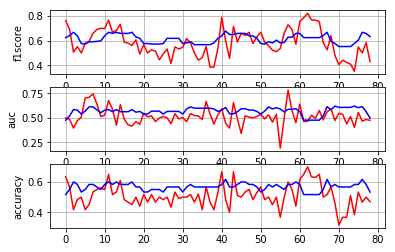

time(in minutes) for 1 epoch 3.466816
remaining time(in minutes) 3425.213925
iteration 12


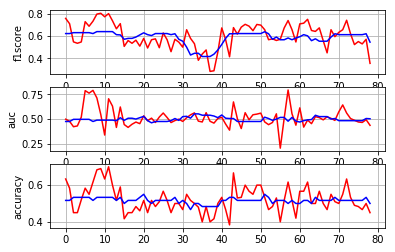

time(in minutes) for 1 epoch 3.473086
remaining time(in minutes) 3427.935831
iteration 13


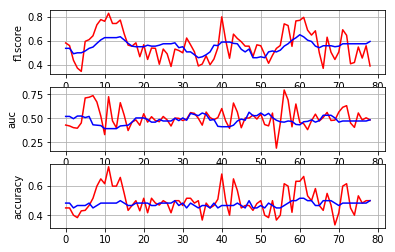

time(in minutes) for 1 epoch 3.466136
remaining time(in minutes) 3417.610016
iteration 14


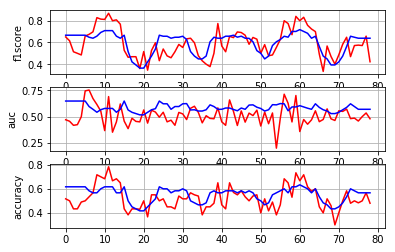

time(in minutes) for 1 epoch 3.466256
remaining time(in minutes) 3414.262538
iteration 15


In [ ]:
# number of times to iterate over whole training dataset
#check_1_time = 1
iter_over_files =  1000
for itera in range(0, iter_over_files):
    now_time = time.time()
    print "iteration %d"%itera
    dir_len = len(file_dir)
    # select file to treat as validation set
    val_file_no = np.random.randint(low=0,high=dir_len)
    val_file = file_dir[val_file_no]
    # train_para and vali_para are storing f1score,auc,accuracy for 
    # train and validation set.
    train_para = []
    vali_para = []
    
#    data_thread = Thread(target=data_processing,args=(val_file,))
#    data_thread.start()
#    data_thread.join()
    # collect validation data in one list to reduce no of parameters
    # to pass between functions
    val_data = [val_file, inde_featuress[val_file_no], \
                sseq_len[val_file_no], target_valuess[val_file_no]]
    # reset these so that these can be used in the below call of data_processing
    #inde_featuress = []
    #sseq_len = []
    #target_valuess = []
    # iterate over each file and train
    for index in range(0, dir_len):
        # do not train on validation file
        if index == val_file_no:
            continue
        #data_thread = Thread(target=data_processing,args=(file_,))
        #data_thread.start()
        #data_thread.join()
        #print "reading data file %s"%file_
        # collect values to form a list to reduce the parameters to be passed
        #train_data = [file_, inde_featuress, sseq_len, target_valuess]
        # reset the values to be used in next call of either val or train set
        train_data = [file_dir[index], inde_featuress[index], \
                    sseq_len[index], target_valuess[index]]
        #inde_featuress = []
        #sseq_len = []
        #target_valuess = []
        
        #if 1!=check_1_time:
        #    tr_ev_thread.join()
#        print thread_inde_features[0].shape
        #tr_ev_thread = Thread(target = train_eval, args = \
        train_eval(train_data, val_data)
        3#tr_ev_thread.start()
        #check_1_time = 0
        
    #tr_ev_thread.join()
    
    t_para = np.asarray(train_para)
    v_para = np.asarray(vali_para)
    
    plot_parameters(t_para, v_para)
    
    time_taken = (time.time()-now_time)/60
    print "time(in minutes) for 1 epoch %f"%(time_taken)
    print "remaining time(in minutes) %f"%(time_taken*(iter_over_files-1-itera))

In [ ]:
# predict values for test data set
print ('opening file for write')
label = ["IdFeedBack,Prediction"]
with open('output.csv', 'wb') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=' ')
    spamwriter.writerow(label)

    for file_ in test_file_dir:
        # get features from current indexed file
        features = get_test_data(file_)        
        # training features is np array with max size and padding
        test_features, seq_len = prepare_data(features, max_seq_len)
        # scale features to have 0 mean and 1 variance
        scaled_features = feature_scaling(test_features, seq_len)
        # find independent components from given features
        inde_features = independent_components(scaled_features, seq_len)
        # evaluate over whole file
        y = np.zeros(0)
        if "Sess05" in file_:
            indices = ["%03d" %(i+1) for i in range(100)]
    #        print file_
            for index in range(0,100,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)
        else:
            indices = ["%03d" %(i+1) for i in range(60)]
            for index in range(0,60,batch_size):
                yfile = observe.eval(feed_dict = {\
                    x:inde_features[index:index+batch_size], \
                    s_len:seq_len[index:index+batch_size]})
                y = np.append(y,yfile)

        for i in xrange(0,y.shape[0]):
            values = [file_[5:-4]+'_FB'+indices[i]+','+str(int(y[i]))]
            spamwriter.writerow(values)
print ('file write complete')